http://www.ipeadata.gov.br/

https://dadosdadosdados.wordpress.com/2015/09/25/trabalhando-com-series-temporais-no-r-parte-i-2/

In [249]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

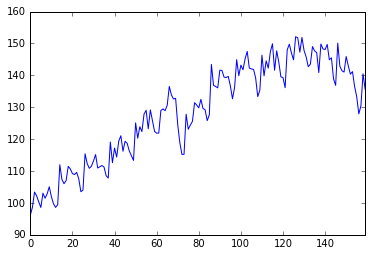

In [250]:
dataset = pd.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataset.columns = ['DATA','IBC_BR']
dataset['IBC_BR'].plot()

In [251]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

In [252]:
# fix random seed for reproducibility
numpy.random.seed(42)

In [253]:
# load the dataset
#dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataframe = pandas.read_csv('ibc_br_20160918.csv', usecols=[0,1], engine='python')
dataframe.columns = ['DATA','IBC_BR']
#dataset = dataframe['IBC_BR'].values.reshape(-1, 1)
#dataset = dataset.astype('float32')

### Add trend and seasonal factor

In [254]:
seasonal = pd.get_dummies(dataframe['DATA'].apply(lambda x: int(str(x).split('.')[-1])))
seasonal.columns = ['D'+str(x) for x in range(1,12)]

In [255]:
data = pd.concat([dataframe, seasonal], axis=1)
data['TREND'] = range(0, dataframe.shape[0])

In [256]:
data['LAG_IBC_BR'] = data.groupby(['DATA'])['IBC_BR'].mean().shift(1).reset_index(drop=True)

In [257]:
data = data.rename(columns={'IBC_BR':'TARGET'})

In [258]:
data = data.fillna(0)

In [259]:
del data['DATA']

In [260]:
data['perc_TARGET'] = data['TARGET']/data['LAG_IBC_BR']-1
data.ix[np.isinf(data['perc_TARGET']),'perc_TARGET'] = 0
target = data['TARGET']
del data['TARGET']

In [261]:
# convert an array of values into a dataset matrix
def create_dataset(df):
    dataX, dataY = [], []
    dataY = df['perc_TARGET']
    dataX = df.ix[:, df.columns != 'perc_TARGET']
    
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataX = scaler.fit_transform(dataX)
        
    return numpy.array(dataX), numpy.array(dataY)

In [262]:
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data.loc[0:train_size,:], data.loc[train_size:len(data),:]
print(len(train), len(test))

(108, 53)


In [263]:
# reshape into X=t and Y=t+1
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

In [264]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [265]:
# import numpy as np
# from keras import backend as K
# def mean_squared_error(y_true, y_pred):
#     return K.mean(K.square(y_true - y_pred), axis=-1)

# def rsquared(y_true, y_pred):
#     ssres = K.mean(K.square(y_true - y_pred), axis=-1)
#     sstot = K.square(y_true -K.mean(y_true))
#     rsquare = (1 - (ssres/sstot))
#     return rsquare

# def sum_squared_error(y_true, y_pred):
#     return K.sum(K.square(y_true - y_pred), axis=-1)

In [307]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(12, input_dim=(data.shape[1]-1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(12,return_sequences=True))
model.add(Dropout(0.2))
#model.add(LSTM(12,return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(12))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

hist = model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2, validation_split=0.3)

Train on 75 samples, validate on 33 samples
Epoch 1/100
0s - loss: 0.0012 - val_loss: 8.3968e-04
Epoch 2/100
0s - loss: 0.0012 - val_loss: 6.5209e-04
Epoch 3/100
0s - loss: 9.4257e-04 - val_loss: 5.2552e-04
Epoch 4/100
0s - loss: 9.2509e-04 - val_loss: 4.4721e-04
Epoch 5/100
0s - loss: 8.2566e-04 - val_loss: 4.0501e-04
Epoch 6/100
0s - loss: 6.7424e-04 - val_loss: 2.8121e-04
Epoch 7/100
0s - loss: 6.5199e-04 - val_loss: 2.8273e-04
Epoch 8/100
0s - loss: 7.8689e-04 - val_loss: 2.9273e-04
Epoch 9/100
0s - loss: 8.0450e-04 - val_loss: 3.3679e-04
Epoch 10/100
0s - loss: 6.5109e-04 - val_loss: 2.8805e-04
Epoch 11/100
0s - loss: 6.0799e-04 - val_loss: 2.5273e-04
Epoch 12/100
0s - loss: 5.5646e-04 - val_loss: 2.4842e-04
Epoch 13/100
0s - loss: 4.2270e-04 - val_loss: 3.0613e-04
Epoch 14/100
0s - loss: 5.3653e-04 - val_loss: 3.0418e-04
Epoch 15/100
0s - loss: 6.2492e-04 - val_loss: 3.0166e-04
Epoch 16/100
0s - loss: 6.0966e-04 - val_loss: 3.8093e-04
Epoch 17/100
0s - loss: 6.4424e-04 - val_loss

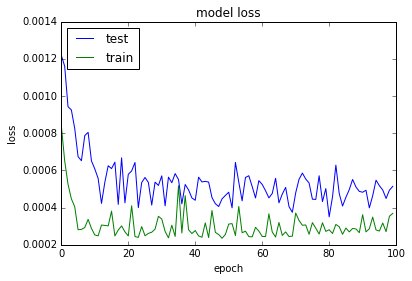

In [308]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper left')

In [309]:
# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

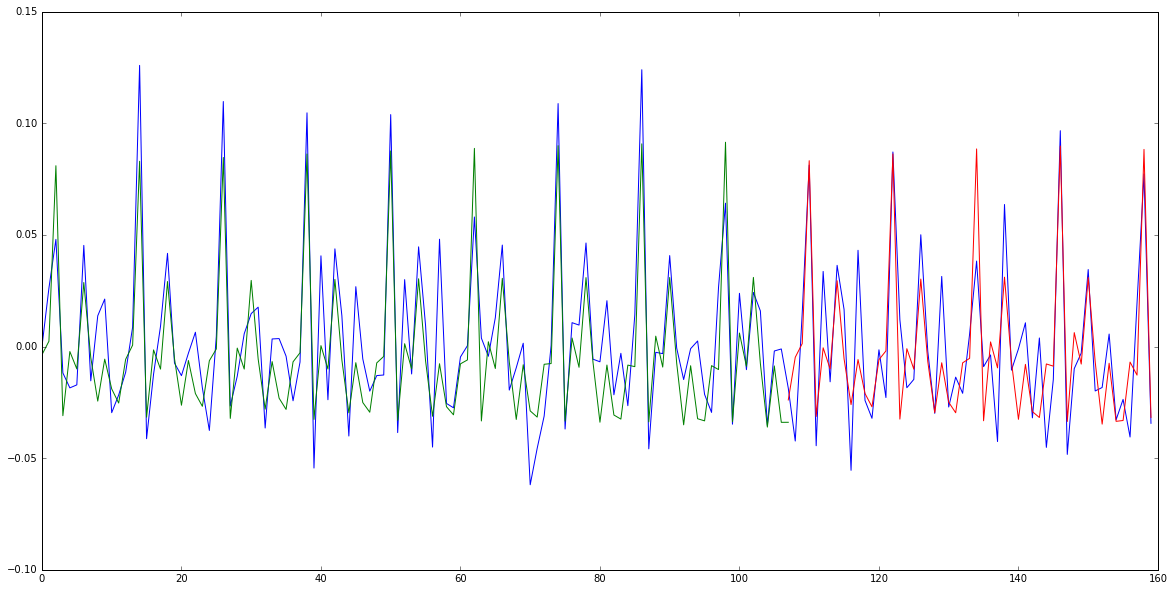

In [310]:
trainPredictPlot = np.zeros((data.shape[0],1))
trainPredictPlot[:,:] = np.nan
trainPredictPlot[0:len(trainPredict),:] = trainPredict

testPredictPlot = np.zeros((data.shape[0],1))
testPredictPlot[:,:] = np.nan
testPredictPlot[-len(testPredict):len(data),:] = testPredict

# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(data['perc_TARGET'])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

In [311]:
plotTrain = (1+trainPredictPlot[:,0])*data['LAG_IBC_BR']
plotTest = (1+testPredictPlot[:,0])*data['LAG_IBC_BR']

(95, 160)

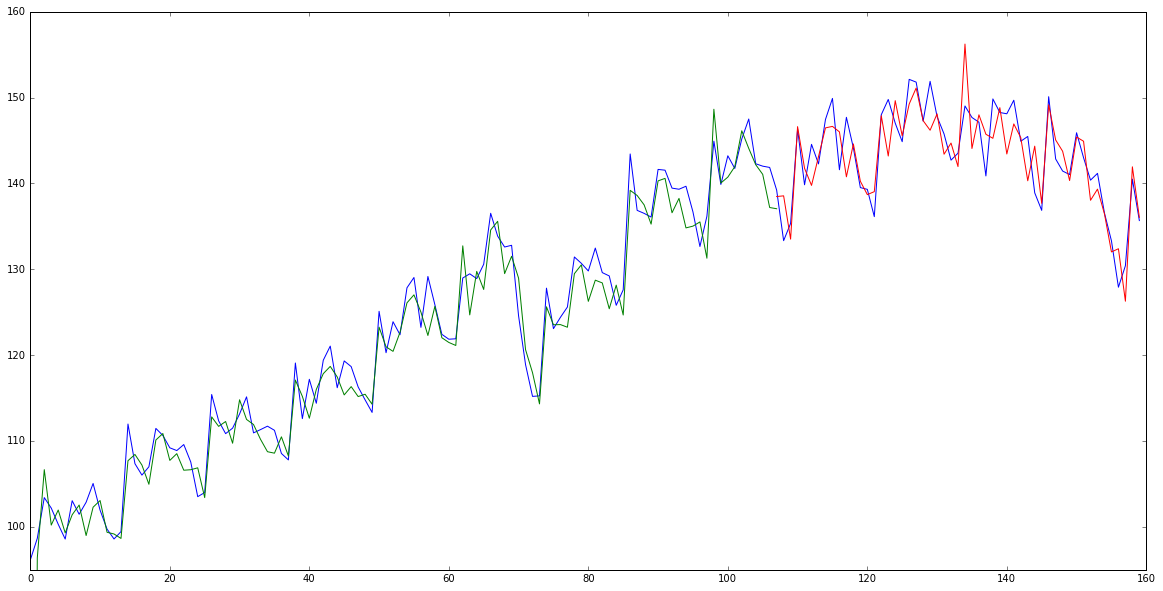

In [312]:
# plot baseline and predictions
plt.figure(figsize=(20,10))
#plt.plot(data['perc_TARGET'])
plt.plot(target)
plt.plot(plotTrain)
plt.plot(plotTest)
plt.ylim(95,160)

In [313]:
train_r2 = round(r2_score(target[1:len(trainPredict)], plotTrain[1:len(trainPredict)]),2)
test_r2 = round(r2_score(target[-len(testPredict):len(plotTest)],plotTest[-len(testPredict):len(plotTest)]),2)
print 'Train R2 - %s' % train_r2, ' / ','Test R2 - %s' % test_r2


Train R2 - 0.97  /  Test R2 - 0.69
